In [1]:
from geoips.interfaces import readers as geoips_readers
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from functools import lru_cache
import hashlib
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import os
import io
from PIL import Image
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interactive, Layout, VBox, HBox, Tab
import matplotlib.pyplot as plt
import numpy as np

In [2]:
reader = geoips_readers.get_plugin("geoips_aviris_ng")

In [3]:
#data = reader(fnames=["/data/ang20170321t194012_rfl_v2p5/ang20170321t194012_corr_v2p5_img"])

In [4]:
data = reader(fnames=["/data/ang20170321t213141_rfl_v2p5/ang20170321t213141_corr_v2p5_img"])

In [5]:
# Modified caching function for xarray datasets
def get_band_data_xarray(dataset, band_name, x_start, y_start, x_end, y_end):
    """Function to get band data from an xarray dataset."""
    data = dataset[band_name].isel(x=slice(x_start, x_end), y=slice(y_start, y_end)).values
    data = data.astype(float)
    data[data == -9999.] = np.nan
    return data

def get_cache_key_xarray(dataset, wavelength, px, py, window_size, offset_x, offset_y):
    """Generate a unique cache key based on input parameters."""
    # Use dataset attributes to create a unique identifier
    if hasattr(dataset, 'source_file_names'):
        dataset_id = str(dataset.source_file_names)
    else:
        dataset_id = str(dataset.dims)
    
    key_str = f"{dataset_id}_{wavelength}_{px}_{py}_{window_size}_{offset_x}_{offset_y}"
    return hashlib.md5(key_str.encode()).hexdigest()


In [6]:
def plot_wavelength_image_with_spectrum_xarray(dataset, wavelength, px=None, py=None, site_name="Site", 
                                       figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                                       arrow_color='red', band_dictionary=None, cache_dir=None,
                                       window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                                       image_title=None, spectrum_title=None, 
                                       spectral_point_x=None, spectral_point_y=None, 
                                       show_crosshair=False, crosshair_color='white', 
                                       crosshair_alpha=0.5, crosshair_linewidth=1,
                                       center_x=None, center_y=None, vmin=None, vmax=None):
    """
    Plot imagery at the top and spectral curve at the bottom with connecting markers
    using xarray Dataset instead of GDAL.
    
    Parameters:
    -----------
    dataset : xarray.Dataset or dict
        The xarray dataset containing hyperspectral imagery or a dictionary with 'AVIRIS-NG-L1-RADIANCE' key
    wavelength : float
        The wavelength (in nm) to plot. The function will find the closest band.
    px, py : int, optional
        Pixel coordinates (x, y) indices for the point of interest. If None, spectral_point_x and spectral_point_y must be provided.
    site_name : str
        Name of the site/point being analyzed
    figsize : tuple
        Figure size (width, height) in inches
    img_cmap : str
        Colormap to use for the image. Default is 'gray'.
    arrow_position : tuple
        (x, y) position for the north arrow in data coordinates
    arrow_color : str
        Color of the arrow
    band_dictionary : dict
        Dictionary defining spectral regions. If None, a default will be used.
    cache_dir : str
        Directory to store cached data. If None, no caching will be used.
    window_size : int
        Size of the square window to extract around the center (in pixels)
    offset_x, offset_y : int
        Offset from the center of the image (in pixels)
    north_arrow_angle : float
        Angle of the north arrow from the y-axis in degrees (clockwise positive)
    image_title : str, optional
        Custom title for the image plot. If None, a default title will be used.
    spectrum_title : str, optional
        Custom title for the spectrum plot. If None, a default title will be used.
    spectral_point_x, spectral_point_y : int, optional
        Alternative way to specify the pixel coordinates for the spectral point. 
        If provided, these will override px and py.
    show_crosshair : bool, optional
        Whether to show a crosshair at the spectral point location. Default is False.
    crosshair_color : str, optional
        Color of the crosshair. Default is 'white'.
    crosshair_alpha : float, optional
        Transparency of the crosshair (0-1). Default is 0.5.
    crosshair_linewidth : float, optional
        Line width of the crosshair. Default is 1.
    center_x, center_y : int, optional
        Specific pixel coordinates to center the map on. If None, the map will be centered on the 
        middle of the image with any offset_x and offset_y applied.
    vmin, vmax : float, optional
        Minimum and maximum values for the colorbar. If None, the min and max values of the data will be used.
        
    Returns:
    --------
    fig : matplotlib figure object
    """
    # Start timing
    start_time = time.time()
    
    # Use spectral_point_x/y if provided, otherwise use px/py
    if spectral_point_x is not None and spectral_point_y is not None:
        px, py = spectral_point_x, spectral_point_y
    
    # Ensure px and py are provided
    if px is None or py is None:
        raise ValueError("Either (px, py) or (spectral_point_x, spectral_point_y) must be provided")
    
    # Get the dataset that contains the radiance data
    if isinstance(dataset, dict) and 'AVIRIS-NG-L1-RADIANCE' in dataset:
        data_ds = dataset['AVIRIS-NG-L1-RADIANCE']
    else:
        data_ds = dataset
    
    # Create cache directory if it doesn't exist
    if cache_dir is not None:
        os.makedirs(cache_dir, exist_ok=True)
        
        # Create cache filename based on input parameters
        cache_key = get_cache_key_xarray(data_ds, wavelength, px, py, window_size, offset_x, offset_y)
        if center_x is not None and center_y is not None:
            cache_key += f"_center_{center_x}_{center_y}"
        cache_path = os.path.join(cache_dir, f"{cache_key}.pkl")
        
        # Try to load from cache
        if os.path.exists(cache_path):
            try:
                #print(f"Loading cached data from {cache_path}")
                with open(cache_path, 'rb') as f:
                    cache_data = pickle.load(f)
                    
                    # Extract all needed data from cache
                    band_names = cache_data['band_names']
                    band_centers = cache_data['band_centers']
                    spectrum = cache_data['spectrum']
                    closest_band_idx = cache_data['closest_band_idx']
                    closest_band_name = cache_data['closest_band_name']
                    actual_wavelength = cache_data['actual_wavelength']
                    nrows, ncols = cache_data['dimensions']
                    x_start, x_end, y_start, y_end = cache_data['window_coords']
                    band_data = cache_data['band_data']
                    window_extent = cache_data['window_extent']
                    x_coord, y_coord = cache_data['pixel_coords']
                    
                    cached_data_loaded = True
                    #print(f"Cache loaded in {time.time() - start_time:.2f} seconds")
            except Exception as e:
                print(f"Error loading cache: {e}")
                cached_data_loaded = False
        else:
            cached_data_loaded = False
    else:
        cached_data_loaded = False
    
    # If cache wasn't loaded, compute the data
    if not cached_data_loaded:
        # Get dimensions
        nrows = data_ds.dims['y']
        ncols = data_ds.dims['x']
        
        # Extract band information from variable names
        band_names = [var for var in data_ds.data_vars if 'nm_rad' in var]
        
        # Extract wavelengths from band names
        band_centers = []
        for name in band_names:
            # Extract wavelength from band name (e.g., "violet_376nm_rad" -> 376)
            parts = name.split('_')
            for part in parts:
                if 'nm' in part:
                    band_centers.append(float(part.replace('nm', '')))
                    break
        
        # Find the band closest to the requested wavelength
        closest_band_idx = np.argmin(np.abs(np.array(band_centers) - wavelength))
        closest_band_name = band_names[closest_band_idx]
        actual_wavelength = band_centers[closest_band_idx]
        
        # Get the full spectrum for the selected point
        #print("Extracting spectral data...")
        spectrum = []
        for band_name in band_names:
            pixel_data = data_ds[band_name].isel(x=px, y=py).values
            spectrum.append(float(pixel_data))
        #print(f"Spectral data extracted in {time.time() - start_time:.2f} seconds")
        
        # Calculate the window coordinates with offset
        # Determine the center point for the window
        if center_x is not None and center_y is not None:
            # Use the specified center coordinates
            center_x_with_offset = center_x + offset_x
            center_y_with_offset = center_y + offset_y
        else:
            # Use the default center (middle of the image) with offset
            center_x_with_offset = (ncols // 2) + offset_x
            center_y_with_offset = (nrows // 2) + offset_y
        
        # Calculate window boundaries
        half_window = window_size // 2
        x_start = max(0, center_x_with_offset - half_window)
        x_end = min(ncols, center_x_with_offset + half_window)
        y_start = max(0, center_y_with_offset - half_window)
        y_end = min(nrows, center_y_with_offset + half_window)
        
        # Read only the window of interest for the selected band
        #print(f"Loading band {closest_band_name} for image display...")
        # Using the function without caching
        band_data = get_band_data_xarray(data_ds, closest_band_name, x_start, y_start, x_end, y_end)
        #print(f"Band data loaded in {time.time() - start_time:.2f} seconds")
        
        # Get coordinate values for the window extent
        x_coords = data_ds.x.values
        y_coords = data_ds.y.values
        
        # Calculate extent for the window
        window_extent = [
            x_coords[x_start],
            x_coords[x_end-1],
            y_coords[y_end-1],
            y_coords[y_start]
        ]
        
        # Get the real-world coordinates of the pixel
        x_coord = data_ds.x.values[px]
        y_coord = data_ds.y.values[py]
        
        # Save to cache if enabled
        if cache_dir is not None:
            cache_data = {
                'band_names': band_names,
                'band_centers': band_centers,
                'spectrum': spectrum,
                'closest_band_idx': closest_band_idx,
                'closest_band_name': closest_band_name,
                'actual_wavelength': actual_wavelength,
                'dimensions': (nrows, ncols),
                'window_coords': (x_start, x_end, y_start, y_end),
                'band_data': band_data,
                'window_extent': window_extent,
                'pixel_coords': (x_coord, y_coord)
            }
            with open(cache_path, 'wb') as f:
                pickle.dump(cache_data, f)
            #print(f"Data cached to {cache_path}")
    
    # Default band dictionary if none provided
    if band_dictionary is None:
        band_dictionary = {
            "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
            "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
            "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
            "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
            "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
            "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
            "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
            "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
            "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
        }
    
    # Create a DataFrame for the spectrum
    spectrum_df = pd.DataFrame({
        "Band name": band_names,
        "Band center (nm)": band_centers,
        f"{site_name} radiance": spectrum
    })
    
    # Create the figure - this part is always executed (not cached)
    fig = plt.figure(figsize=figsize)
    
    # Create GridSpec with different height ratios
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    
    # Title font dictionary
    titlefont = {'fontsize': 16, 'fontweight': 2,
                 'verticalalignment': 'baseline', 'horizontalalignment': 'center'}
    
    # Top subplot for the image
    ax_image = fig.add_subplot(gs[0])
    
    # Plot the image with vmin and vmax if provided
    im = ax_image.imshow(band_data, cmap=img_cmap, extent=window_extent, vmin=vmin, vmax=vmax)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_image)
    cbar.set_label('Radiance', fontsize=12)
    
    # Check if the point is within the window
    point_in_window = (x_start <= px < x_end) and (y_start <= py < y_end)
    
    # Mark the selected pixel on the image if it's within the window
    if point_in_window:
        ax_image.plot(x_coord, y_coord, 'ro', markersize=10, markeredgecolor='white')
    
    # Add crosshair if requested - do this regardless of whether point is in window
    if show_crosshair and point_in_window:
        #print(f"Drawing crosshair at coordinates ({x_coord}, {y_coord})")
        
        # Draw horizontal line across the full width of the displayed image
        ax_image.axhline(y=y_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
        
        # Draw vertical line across the full height of the displayed image
        ax_image.axvline(x=x_coord, color=crosshair_color, alpha=crosshair_alpha, 
                       linewidth=crosshair_linewidth, zorder=1)
    elif show_crosshair and not point_in_window:
        print("Point is outside the current window. Crosshair not drawn.")
        
    # Image plot configuration
    # Use custom title if provided, otherwise use default
    if image_title is None:
        image_title = f"Imagery at {actual_wavelength:.2f} nm (Band {closest_band_name})"
    ax_image.set_title(image_title, fontdict=titlefont, pad=15)
    
    ax_image.set_xlabel('Easting (m)', fontsize=14)
    ax_image.set_ylabel('Northing (m)', fontsize=14)
    ax_image.tick_params(axis='both', which='major', labelsize=12)
    ax_image.grid(alpha=0.3, linestyle='--')
    
    # Add north arrow
    if arrow_position is None:
        # Default position in the upper left if not specified
        arrow_position = (window_extent[0] + 0.9 * (window_extent[1] - window_extent[0]), 
                          window_extent[3] - 0.2 * (window_extent[3] - window_extent[2]))
    
    arrow_length =   0.1 * (window_extent[3] - window_extent[2])  # 10% of the y-axis length
    
    # Calculate arrow components based on the angle
    import math
    angle_rad = math.radians(north_arrow_angle)
    dx = arrow_length * math.sin(angle_rad)
    
    dy = arrow_length * math.cos(angle_rad)
    
    # Draw the arrow with the specified angle
    ax_image.arrow(arrow_position[0], arrow_position[1], dx, dy, 
                  head_width=arrow_length/5, head_length=arrow_length/3, 
                  fc=arrow_color, ec=arrow_color, linewidth=3)
    
    # Add "North" text next to the arrow
    text_offset = 1.7 * arrow_length
    text_x = arrow_position[0] + dx * 1.6
    text_y = arrow_position[1] + dy * 1.6
    ax_image.text(text_x, text_y, 'N', fontsize=14, ha='center', color=arrow_color, fontweight='bold')
    
    # Bottom subplot for the spectrum
    ax_spectrum = fig.add_subplot(gs[1])
    
    # Plot the spectrum
    spectrum_df.plot(x='Band center (nm)', y=f"{site_name} radiance", 
                    ax=ax_spectrum, c='black', label='_nolegend_', legend=False)
    
    # Add shaders for band regions
    for region, limits in band_dictionary.items():
        ax_spectrum.axvspan(limits['lower'], limits['upper'], alpha=0.2, 
                           color=limits['color'], label=region)
    
    # Add water vapor region shaders
    ax_spectrum.axvspan(1340, 1445, alpha=0.1, color='blue', label='water vapor regions')
    ax_spectrum.axvspan(1790, 1955, alpha=0.1, color='blue')
    
    # Add vertical line at the selected wavelength
    ax_spectrum.axvline(x=actual_wavelength, color='red', linestyle='--', linewidth=2, 
                       label=f'Selected wavelength: {actual_wavelength:.2f} nm')
    
    # Mark the radiance value at the selected wavelength
    radiance_at_wavelength = spectrum[closest_band_idx]
    ax_spectrum.plot(actual_wavelength, radiance_at_wavelength, 'ro', markersize=8)
    
    # Spectrum plot configuration
    ax_spectrum.set_xlim(min(band_centers), max(band_centers))
    ax_spectrum.set_ylabel("Radiance", fontsize=16)
    ax_spectrum.set_xlabel("Wavelength (nm)", fontsize=16)
    ax_spectrum.tick_params(axis='both', which='major', labelsize=14)
    ax_spectrum.grid('on', alpha=0.25)
    
    # Use custom title if provided, otherwise use default
    if spectrum_title is None:
        spectrum_title = f"Spectral Profile at {site_name} (x={px}, y={py})"
    ax_spectrum.set_title(spectrum_title, fontdict=titlefont, pad=10)
    
    # Add legend to spectrum plot
    legend = ax_spectrum.legend(prop={'size': 12}, loc='center left', 
                               bbox_to_anchor=(1.01, 0.5), ncol=1, framealpha=1)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    #print(f"Total plot generation time: {time.time() - start_time:.2f} seconds")
    
    return fig

In [7]:
def create_wavelength_animation(dataset, wavelengths, px=None, py=None, site_name="Site", 
                               figsize=(16, 12), img_cmap='gray', arrow_position=None, 
                               arrow_color='red', band_dictionary=None, cache_dir=None,
                               window_size=200, offset_x=0, offset_y=0, north_arrow_angle=0,
                               image_title_template="Imagery at {wavelength:.2f} nm",
                               spectrum_title=None, spectral_point_x=None, spectral_point_y=None, 
                               show_crosshair=False, crosshair_color='white', 
                               crosshair_alpha=0.5, crosshair_linewidth=1,
                               center_x=None, center_y=None, frame_duration=500, 
                               repeat=True, save_path=None, save_frames=False, 
                               frames_directory="animation_frames", dpi=100, vmin=None, vmax=None):
    """
    Create an animation that cycles through multiple wavelengths.
    
    New Parameters:
    ---------------
    save_frames : bool, optional
        If True, save each frame as an individual image file. Default is False.
    frames_directory : str, optional
        Directory to save individual frames. Default is "animation_frames".
    """
    import os
    import io
    import tempfile
    from PIL import Image
    from IPython.display import HTML
    
    # Let's use a simpler approach - create and save individual frames, then combine them
    print("Generating frames for animation...")
    
    # Create directories
    temp_dir = None
    if save_path:
        temp_dir = tempfile.mkdtemp()
        print(f"Using temporary directory: {temp_dir}")
    
    if save_frames:
        # Create the frames directory if it doesn't exist
        os.makedirs(frames_directory, exist_ok=True)
        print(f"Individual frames will be saved to: {frames_directory}/")
    
    # Generate each frame
    frames = []
    for i, wavelength in enumerate(wavelengths):
        print(f"Generating frame {i+1}/{len(wavelengths)} - wavelength: {wavelength}nm")
        
        # Calculate wavelength in micrometers for the title
        wavelength_um = wavelength / 1000
        
        # Create a custom image title if template is provided
        if image_title_template:
            custom_image_title = image_title_template.format(wavelength=wavelength, wavelength_um=wavelength_um)
        else:
            custom_image_title = None
        
        # Create a figure for this wavelength
        fig = plot_wavelength_image_with_spectrum_xarray(
            dataset=dataset, 
            wavelength=wavelength, 
            px=px, 
            py=py, 
            site_name=site_name, 
            figsize=figsize, 
            img_cmap=img_cmap, 
            arrow_position=arrow_position, 
            arrow_color=arrow_color, 
            band_dictionary=band_dictionary, 
            cache_dir=cache_dir,
            window_size=window_size, 
            offset_x=offset_x, 
            offset_y=offset_y, 
            north_arrow_angle=north_arrow_angle,
            image_title=custom_image_title, 
            spectrum_title=spectrum_title, 
            spectral_point_x=spectral_point_x, 
            spectral_point_y=spectral_point_y, 
            show_crosshair=show_crosshair, 
            crosshair_color=crosshair_color, 
            crosshair_alpha=crosshair_alpha, 
            crosshair_linewidth=crosshair_linewidth,
            center_x=center_x, 
            center_y=center_y,
            vmin=vmin,
            vmax=vmax,
        )
        
        # Save the figure to a buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
        buf.seek(0)
        
        # Load the image from the buffer
        img = Image.open(buf)
        frames.append(img)
        
        # Save individual frame if requested
        if save_frames:
            frame_filename = f"frame_{i+1:03d}_{wavelength:.0f}nm.png"
            frame_path = os.path.join(frames_directory, frame_filename)
            fig.savefig(frame_path, dpi=dpi, bbox_inches='tight')
            if i == 0:  # Only print for first frame to avoid spam
                print(f"Saving frames as: {frame_filename} (and similar)")
        
        # If saving animation, also save to temp directory
        if save_path and temp_dir:
            temp_frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
            fig.savefig(temp_frame_path, dpi=dpi, bbox_inches='tight')
        
        # Close the figure to free memory
        plt.close(fig)
        
        # Close the buffer
        buf.close()
    
    # Print summary of saved frames
    if save_frames:
        print(f"✓ Saved {len(wavelengths)} individual frames to: {frames_directory}/")
        print(f"  Frame naming pattern: frame_XXX_YYYnm.png")
    
    # Save the animation if a path is provided
    if save_path:
        print(f"Saving animation to {save_path}...")
        try:
            # Try to create a GIF using PIL
            gif_path = save_path.replace('.mp4', '.gif')
            frames[0].save(
                gif_path,
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=frame_duration,
                loop=0 if repeat else 1
            )
            print(f"✓ Animation saved as GIF: {gif_path}")
            
            # Try to create an MP4 if ffmpeg is available
            if temp_dir:
                try:
                    import subprocess
                    
                    # Create a command to convert the frames to MP4
                    cmd = [
                        'ffmpeg',
                        '-y',  # Overwrite output file if it exists
                        '-framerate', str(1000/frame_duration),
                        '-i', os.path.join(temp_dir, 'frame_%03d.png'),
                        '-c:v', 'libx264',
                        '-pix_fmt', 'yuv420p',
                        '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',  # Ensure dimensions are even
                        save_path
                    ]
                    
                    # Run the command
                    result = subprocess.run(cmd, capture_output=True, text=True)
                    if result.returncode == 0:
                        print(f"✓ Animation saved as MP4: {save_path}")
                    else:
                        print(f"ffmpeg error: {result.stderr}")
                        print("GIF version is available instead.")
                except FileNotFoundError:
                    print("ffmpeg not found. Only GIF version created.")
                except Exception as e:
                    print(f"Could not create MP4 (ffmpeg error): {e}")
                    print("GIF version is available instead.")
                
        except Exception as e:
            print(f"Error saving animation: {e}")
        
        # Clean up temporary directory
        if temp_dir:
            try:
                import shutil
                shutil.rmtree(temp_dir)
            except:
                pass
    
    # Create an HTML animation for display in the notebook
    print("Creating HTML animation for notebook display...")
    html_animation = create_html_animation(frames, frame_duration, repeat)
    
    print("✓ Animation complete!")
    return html_animation

def create_html_animation(frames, frame_duration, repeat=True):
    """
    Create an HTML animation from a list of PIL Image objects.
    """
    import base64
    import io
    from IPython.display import HTML
    
    # Convert frames to base64-encoded strings
    base64_frames = []
    for frame in frames:
        buf = io.BytesIO()
        frame.save(buf, format='PNG')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('ascii')
        base64_frames.append(img_str)
        buf.close()
    
    # Create HTML with JavaScript to display the animation
    html = """
    <div id="animation" style="display: inline-block; text-align: center;">
        <img id="animationImage" style="display: block; max-width: 100%;">
        <div style="margin-top: 10px;">
            <button onclick="toggleAnimation()" id="playPauseBtn">Pause</button>
            <button onclick="resetAnimation()">Reset</button>
            <span style="margin-left: 20px;">Frame: <span id="frameCounter">1</span> / {frame_count}</span>
        </div>
    </div>
    
    <script>
        var frames = {frames};
        var frameIndex = 0;
        var frameCount = frames.length;
        var frameDuration = {duration}; // milliseconds
        var repeat = {repeat};
        var animationImage = document.getElementById('animationImage');
        var animationRunning = true;
        var animationTimeout;
        
        function updateFrame() {{
            if (frameIndex >= frameCount) {{
                if (repeat) {{
                    frameIndex = 0;
                }} else {{
                    animationRunning = false;
                    document.getElementById('playPauseBtn').textContent = 'Play';
                    return;
                }}
            }}
            
            animationImage.src = 'data:image/png;base64,' + frames[frameIndex];
            document.getElementById('frameCounter').textContent = frameIndex + 1;
            frameIndex++;
            
            if (animationRunning) {{
                animationTimeout = setTimeout(updateFrame, frameDuration);
            }}
        }}
        
        function toggleAnimation() {{
            var btn = document.getElementById('playPauseBtn');
            if (animationRunning) {{
                animationRunning = false;
                clearTimeout(animationTimeout);
                btn.textContent = 'Play';
            }} else {{
                animationRunning = true;
                btn.textContent = 'Pause';
                updateFrame();
            }}
        }}
        
        function resetAnimation() {{
            frameIndex = 0;
            updateFrame();
            if (!animationRunning) {{
                animationRunning = true;
                document.getElementById('playPauseBtn').textContent = 'Pause';
            }}
        }}
        
        // Start the animation
        updateFrame();
    </script>
    """.format(
        frames=str(base64_frames),
        duration=frame_duration,
        repeat=str(repeat).lower(),
        frame_count=len(base64_frames)
    )
    
    return HTML(html)

In [8]:
wavelengths = [y["wavelength"] for y in [data["AVIRIS-NG-L1-RADIANCE"][x].attrs for x in data["AVIRIS-NG-L1-RADIANCE"].variables] if "wavelength" in y.keys()]

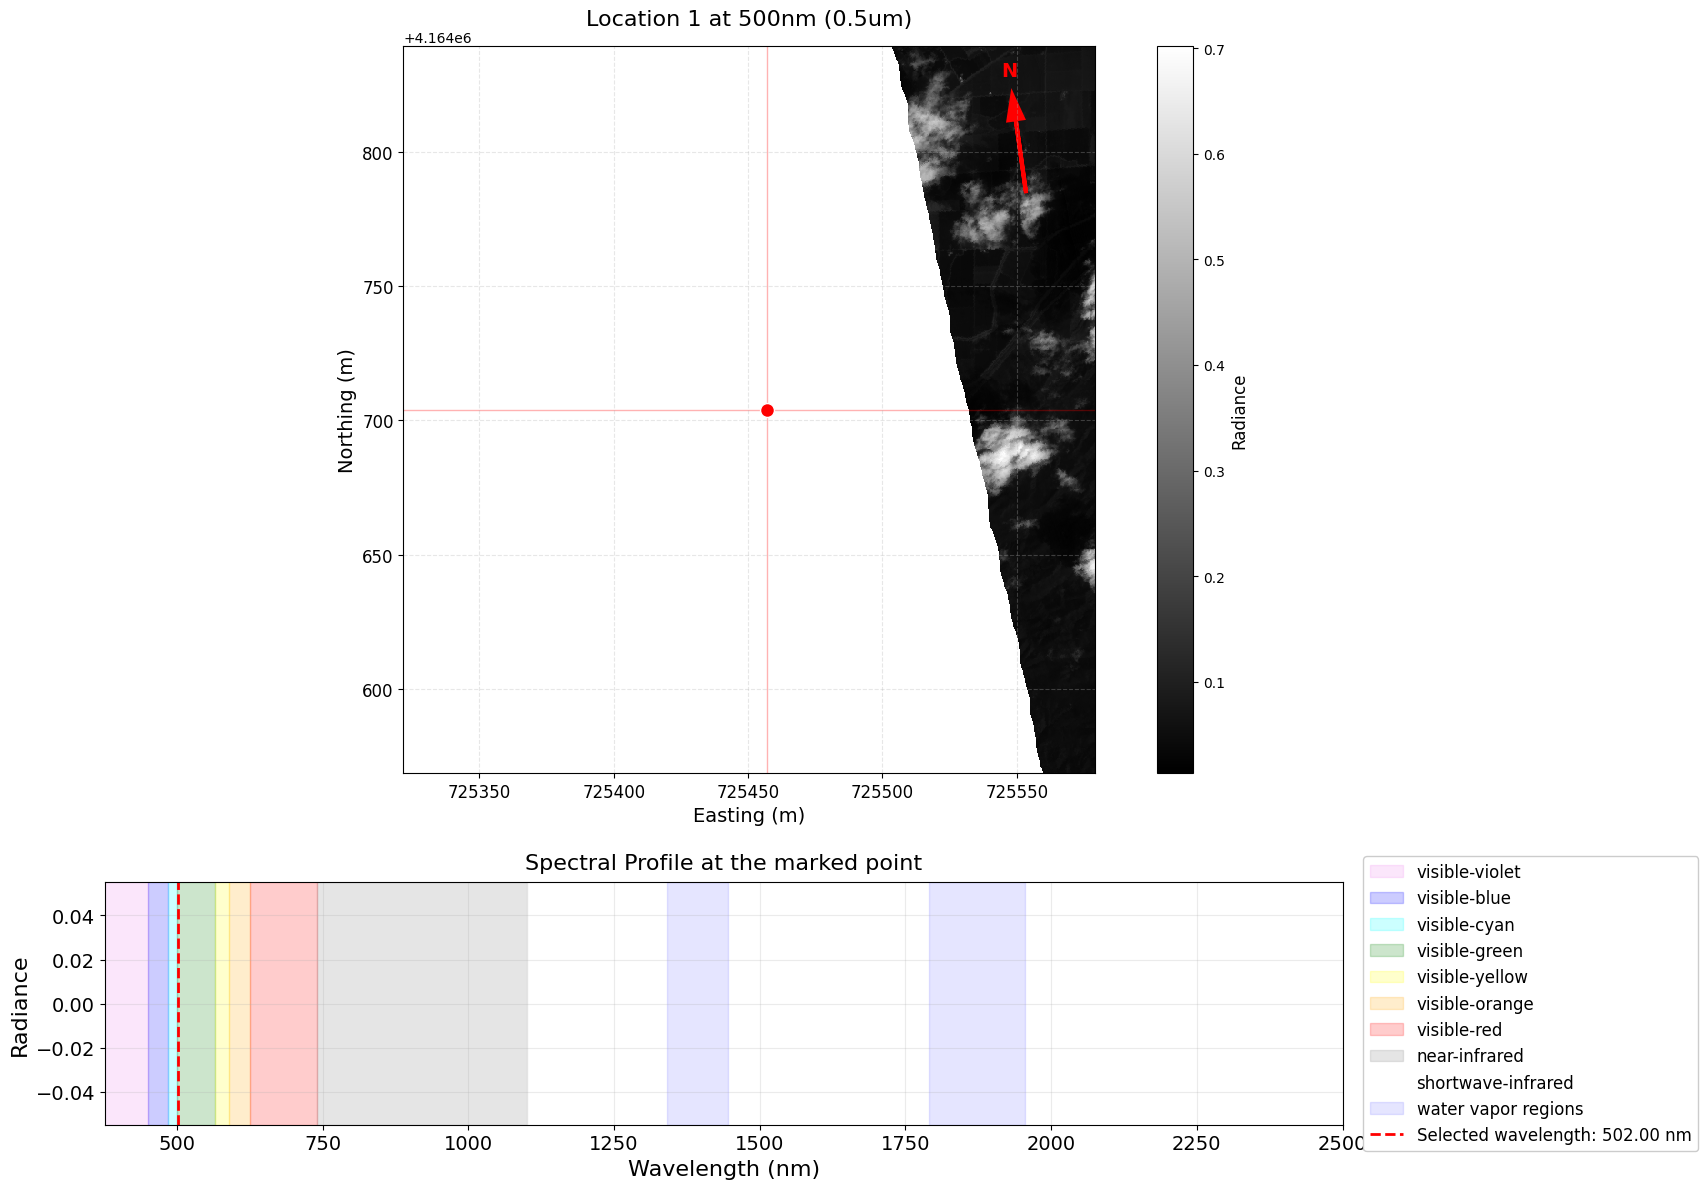

In [9]:
%matplotlib inline
fig1 = plot_wavelength_image_with_spectrum_xarray(
    dataset=data,
    wavelength=500,
    center_x=361,
    center_y=3600,
    px=400,
    py=3600,
    site_name="Site 1",
    window_size=800,
    north_arrow_angle=(360-8),
    image_title="Location 1 at 500nm (0.5um)",
    spectrum_title="Spectral Profile at the marked point",
    show_crosshair=True,
    crosshair_color='red',  # More visible color
    crosshair_alpha=0.3,    # Higher opacity
    crosshair_linewidth=1 # Thicker lines
)
plt.show()

In [10]:
def create_hyperspectral_widgets(dataset, default_values=None):
    """
    Create interactive widgets for the hyperspectral plotting function with animation support.
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        The dataset to use for extracting coordinate ranges
    default_values : dict, optional
        Dictionary of default values to override widget defaults
    """
    
    # Set up default values (including animation defaults)
    defaults = {
        'wavelength': 500,
        'center_x': 361,
        'center_y': 3600,
        'px': 400,
        'py': 3600,
        'site_name': "Site 1",
        'window_size': 800,
        'north_arrow_angle': 352,
        'image_title': "Hyperspectral Image",
        'spectrum_title': "Spectral Profile at the marked point",
        'show_crosshair': True,
        'crosshair_color': 'red',
        'crosshair_alpha': 0.3,
        'crosshair_linewidth': 1,
        # Animation defaults
        'create_animation': False,
        'wl_start': 400,
        'wl_end': 900,
        'wl_step': 100,
        'frame_duration': 100,
        'animation_title_template': "Location 1 at {wavelength:.0f}nm ({wavelength_um:.1f}um)",
        'save_animation': False,
        'save_path': "location1_wavelength_animation_slow.mp4",
        'save_frames': False,
        'frames_directory': "animation_frames",
        'vmin': 0,
        'vmax': 1.8
    }
    
    if default_values:
        defaults.update(default_values)
    
    # Try to get coordinate ranges from dataset
    try:
        if isinstance(dataset, dict) and 'AVIRIS-NG-L1-RADIANCE' in dataset:
            data = dataset['AVIRIS-NG-L1-RADIANCE']
        else:
            data = dataset
            
        x_max = int(data.sizes.get('x', data.sizes.get('longitude', 1000)))
        y_max = int(data.sizes.get('y', data.sizes.get('latitude', 1000)))
        
        # Try to get wavelength range
        if hasattr(data, 'wavelength'):
            wl_min = float(data.wavelength.min())
            wl_max = float(data.wavelength.max())
            available_wavelengths = data.wavelength.values
        else:
            wl_min, wl_max = 400, 2500
            available_wavelengths = np.arange(400, 2500, 10)
    except:
        x_max, y_max = 1000, 1000
        wl_min, wl_max = 400, 2500
        available_wavelengths = np.arange(400, 2500, 10)
    
    # Basic Parameters Tab
    wavelength_widget = widgets.FloatSlider(
        value=defaults['wavelength'],
        min=wl_min,
        max=wl_max,
        step=1,
        description='Wavelength (nm):',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    site_name_widget = widgets.Text(
        value=defaults['site_name'],
        description='Site Name:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Position Parameters
    center_x_widget = widgets.IntSlider(
        value=defaults['center_x'],
        min=0,
        max=x_max,
        step=1,
        description='Center X:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    center_y_widget = widgets.IntSlider(
        value=defaults['center_y'],
        min=0,
        max=y_max,
        step=1,
        description='Center Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    px_widget = widgets.IntSlider(
        value=defaults['px'],
        min=0,
        max=x_max,
        step=1,
        description='Spectrum Point X:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    py_widget = widgets.IntSlider(
        value=defaults['py'],
        min=0,
        max=y_max,
        step=1,
        description='Spectrum Point Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    window_size_widget = widgets.IntSlider(
        value=defaults['window_size'],
        min=100,
        max=2000,
        step=50,
        description='Window Size:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    # Display Parameters
    figsize_width_widget = widgets.IntSlider(
        value=16,
        min=8,
        max=24,
        step=1,
        description='Figure Width:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    figsize_height_widget = widgets.IntSlider(
        value=12,
        min=6,
        max=18,
        step=1,
        description='Figure Height:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    img_cmap_widget = widgets.Dropdown(
        options=['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'jet', 'hot', 'cool'],
        value='gray',
        description='Colormap:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Titles
    image_title_widget = widgets.Text(
        value=defaults['image_title'],
        description='Image Title:',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    spectrum_title_widget = widgets.Text(
        value=defaults['spectrum_title'],
        description='Spectrum Title:',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    # North Arrow Parameters
    north_arrow_angle_widget = widgets.FloatSlider(
        value=defaults['north_arrow_angle'],
        min=0,
        max=360,
        step=1,
        description='North Arrow Angle:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    arrow_color_widget = widgets.Dropdown(
        options=['red', 'blue', 'green', 'yellow', 'black', 'white', 'orange', 'purple'],
        value='red',
        description='Arrow Color:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Crosshair Parameters
    show_crosshair_widget = widgets.Checkbox(
        value=defaults['show_crosshair'],
        description='Show Crosshair',
        style={'description_width': 'initial'}
    )
    
    crosshair_color_widget = widgets.Dropdown(
        options=['red', 'white', 'blue', 'green', 'yellow', 'black', 'orange', 'purple'],
        value=defaults['crosshair_color'],
        description='Crosshair Color:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    crosshair_alpha_widget = widgets.FloatSlider(
        value=defaults['crosshair_alpha'],
        min=0.1,
        max=1.0,
        step=0.1,
        description='Crosshair Alpha:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    crosshair_linewidth_widget = widgets.FloatSlider(
        value=defaults['crosshair_linewidth'],
        min=0.5,
        max=5.0,
        step=0.5,
        description='Crosshair Width:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Color Scale Parameters
    vmin_widget = widgets.FloatText(
        value=defaults['vmin'],
        description='V Min:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    vmax_widget = widgets.FloatText(
        value=defaults['vmax'],
        description='V Max:',
        style={'description_width': 'initial'},
        layout=Layout(width='200px')
    )
    
    # Offset Parameters
    offset_x_widget = widgets.IntSlider(
        value=0,
        min=-500,
        max=500,
        step=10,
        description='Offset X:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    offset_y_widget = widgets.IntSlider(
        value=0,
        min=-500,
        max=500,
        step=10,
        description='Offset Y:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    # Animation Parameters
    create_animation_widget = widgets.Checkbox(
        value=defaults['create_animation'],
        description='Create Animation',
        style={'description_width': 'initial'}
    )
    
    # Wavelength range for animation
    wl_start_widget = widgets.FloatSlider(
        value=defaults['wl_start'],
        min=wl_min,
        max=wl_max,
        step=10,
        description='Start Wavelength:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    wl_end_widget = widgets.FloatSlider(
        value=defaults['wl_end'],
        min=wl_min,
        max=wl_max,
        step=10,
        description='End Wavelength:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    wl_step_widget = widgets.IntSlider(
        value=defaults['wl_step'],
        min=1,
        max=100,
        step=1,
        description='Wavelength Step:',
        style={'description_width': 'initial'},
        layout=Layout(width='300px')
    )
    
    frame_duration_widget = widgets.IntSlider(
        value=defaults['frame_duration'],
        min=50,
        max=2000,
        step=50,
        description='Frame Duration (ms):',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    animation_title_template_widget = widgets.Text(
        value=defaults['animation_title_template'],
        description='Animation Title Template:',
        style={'description_width': 'initial'},
        layout=Layout(width='600px')
    )
    
    save_animation_widget = widgets.Checkbox(
        value=defaults['save_animation'],
        description='Save Animation',
        style={'description_width': 'initial'}
    )
    
    save_path_widget = widgets.Text(
        value=defaults['save_path'],
        description='Save Path:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    # Frame saving parameters
    save_frames_widget = widgets.Checkbox(
        value=defaults['save_frames'],
        description='Save Individual Frames',
        style={'description_width': 'initial'}
    )
    
    frames_directory_widget = widgets.Text(
        value=defaults['frames_directory'],
        description='Frames Directory:',
        style={'description_width': 'initial'},
        layout=Layout(width='400px')
    )
    
    # Create execute button
    execute_button = widgets.Button(
        description='Generate Plot/Animation',
        button_style='primary',
        layout=Layout(width='200px', height='40px')
    )
    
    # Create output widget for results
    output_widget = widgets.Output()
    
    # Create tabs for organization
    basic_tab = VBox([
        HBox([wavelength_widget]),
        HBox([site_name_widget]),
        HBox([image_title_widget]),
        HBox([spectrum_title_widget])
    ])
    
    position_tab = VBox([
        HBox([center_x_widget, center_y_widget]),
        HBox([px_widget, py_widget]),
        HBox([window_size_widget]),
        HBox([offset_x_widget, offset_y_widget])
    ])
    
    display_tab = VBox([
        HBox([figsize_width_widget, figsize_height_widget]),
        HBox([img_cmap_widget]),
        HBox([vmin_widget, vmax_widget])
    ])
    
    arrow_crosshair_tab = VBox([
        HBox([north_arrow_angle_widget, arrow_color_widget]),
        HBox([show_crosshair_widget]),
        HBox([crosshair_color_widget]),
        HBox([crosshair_alpha_widget, crosshair_linewidth_widget])
    ])
    
    animation_tab = VBox([
        HBox([create_animation_widget]),
        HBox([wl_start_widget, wl_end_widget]),
        HBox([wl_step_widget, frame_duration_widget]),
        HBox([animation_title_template_widget]),
        HBox([save_animation_widget, save_path_widget]),
        HBox([save_frames_widget, frames_directory_widget])
    ])
    
    # Create tabbed interface
    tab = Tab()
    tab.children = [basic_tab, position_tab, display_tab, arrow_crosshair_tab, animation_tab]
    tab.set_title(0, 'Basic')
    tab.set_title(1, 'Position')
    tab.set_title(2, 'Display')
    tab.set_title(3, 'Arrow & Crosshair')
    tab.set_title(4, 'Animation')
    
    # Define the plotting function
    def on_button_click(b):
        with output_widget:
            output_widget.clear_output()
            
            # Get all widget values - using proper variable names
            wavelength = wavelength_widget.value
            site_name = site_name_widget.value
            center_x = center_x_widget.value
            center_y = center_y_widget.value
            px = px_widget.value
            py = py_widget.value
            window_size = window_size_widget.value
            figsize_width = figsize_width_widget.value
            figsize_height = figsize_height_widget.value
            img_cmap = img_cmap_widget.value
            image_title = image_title_widget.value
            spectrum_title = spectrum_title_widget.value
            north_arrow_angle = north_arrow_angle_widget.value
            arrow_color = arrow_color_widget.value
            show_crosshair = show_crosshair_widget.value
            crosshair_color = crosshair_color_widget.value
            crosshair_alpha = crosshair_alpha_widget.value
            crosshair_linewidth = crosshair_linewidth_widget.value
            vmin = vmin_widget.value
            vmax = vmax_widget.value
            offset_x = offset_x_widget.value
            offset_y = offset_y_widget.value
            create_animation = create_animation_widget.value
            wl_start = wl_start_widget.value
            wl_end = wl_end_widget.value
            wl_step = wl_step_widget.value
            frame_duration = frame_duration_widget.value
            animation_title_template = animation_title_template_widget.value
            save_animation = save_animation_widget.value
            save_path = save_path_widget.value
            save_frames = save_frames_widget.value
            frames_directory = frames_directory_widget.value
            
            # Handle None values for vmin/vmax
            vmin = None if vmin == 0 else vmin
            vmax = None if vmax == 0 else vmax
            
            if create_animation:
                # Create wavelength array for animation
                wavelengths = np.arange(wl_start, wl_end + wl_step, wl_step)
                
                print(f"Creating animation with {len(wavelengths)} frames...")
                print(f"Wavelength range: {wl_start} - {wl_end} nm (step: {wl_step} nm)")
                
                if save_frames:
                    print(f"Individual frames will be saved to: {frames_directory}/")
                
                # Prepare save path
                animation_save_path = save_path if save_animation else None
                frames_save_dir = frames_directory if save_frames else None
                
                try:
                    animation = create_wavelength_animation(
                        dataset=dataset,
                        wavelengths=wavelengths,
                        center_x=center_x,
                        center_y=center_y,
                        px=px,
                        py=py,
                        site_name=site_name,
                        window_size=window_size,
                        north_arrow_angle=north_arrow_angle,
                        image_title_template=animation_title_template,
                        spectrum_title=spectrum_title,
                        show_crosshair=show_crosshair,
                        crosshair_color=crosshair_color,
                        crosshair_alpha=crosshair_alpha,
                        crosshair_linewidth=crosshair_linewidth,
                        frame_duration=frame_duration,
                        save_path=animation_save_path,
                        save_frames=save_frames,
                        frames_directory=frames_save_dir,
                        vmin=vmin,
                        vmax=vmax,
                        figsize=(figsize_width, figsize_height),
                        img_cmap=img_cmap,
                        arrow_color=arrow_color,
                        offset_x=offset_x,
                        offset_y=offset_y
                    )
                    
                    if save_animation:
                        print(f"Animation saved to: {save_path}")
                    
                    if save_frames:
                        print(f"Individual frames saved to: {frames_directory}/")
                    
                    display(animation)
                    
                except Exception as e:
                    print(f"Error creating animation: {str(e)}")
                    print("Falling back to single frame plot...")
                    create_animation = False
            
            if not create_animation:
                # Create single plot
                fig = plot_wavelength_image_with_spectrum_xarray(
                    dataset=dataset,
                    wavelength=wavelength,
                    center_x=center_x,
                    center_y=center_y,
                    px=px,
                    py=py,
                    site_name=site_name,
                    window_size=window_size,
                    north_arrow_angle=north_arrow_angle,
                    image_title=image_title,
                    spectrum_title=spectrum_title,
                    show_crosshair=show_crosshair,
                    crosshair_color=crosshair_color,
                    crosshair_alpha=crosshair_alpha,
                    crosshair_linewidth=crosshair_linewidth,
                    figsize=(figsize_width, figsize_height),
                    img_cmap=img_cmap,
                    arrow_color=arrow_color,
                    vmin=vmin,
                    vmax=vmax,
                    offset_x=offset_x,
                    offset_y=offset_y
                )
                plt.show()
    
    # Connect button to function
    execute_button.on_click(on_button_click)
    
    # Return the complete widget interface
    return VBox([
        tab,
        HBox([execute_button]),
        output_widget
    ])


In [11]:
%matplotlib inline

hyperspectral_widgets = create_hyperspectral_widgets(
    dataset=data,
    default_values={
        'wavelength': 500,
        'center_x': 361,
        'center_y': 3600,
        'px': 400,
        'py': 3600,
        'site_name': "Site 1",
        'window_size': 800,
        'north_arrow_angle': (360-8),
        'image_title': "Location 1 at 500nm (0.5um)",
        'spectrum_title': "Spectral Profile at the marked point",
        'show_crosshair': True,
        'crosshair_color': 'red',
        'crosshair_alpha': 0.3,
        'crosshair_linewidth': 1,
        'create_animation': False,
        'wl_start': 400,
        'wl_end': 900,
        'wl_step': 100,
        'frame_duration': 100,
        'animation_title_template': "Location 1 at {wavelength:.0f}nm ({wavelength_um:.1f}um)",
        'save_animation': True,
        'save_path': "location1_wavelength_animation_slow.mp4",
        'save_frames': True,
        'frames_directory': "animation_frames",
        'vmin': 0,
        'vmax': 1.8
    }
)

hyperspectral_widgets